# Price Simulation

We have a few ways for generating prices.

### Collateral Prices

We simulate collateral prices (e.g. WETH) as correlated GBMs. We estimate the generative GBM parameters using historical data from Coingecko (see `scripts/gen_price_config.py`).

### Stablecoin Prices

We simulate stablecoin prices (e.g. USDC) as correlated Ornstein-Uhlenbeck (OU) processes. These are simply mean-reverting GBMs. We similarly estimate the generative OU parameters using a Maximum Likelihood Estimator (MLE) on historical Coingecko data (see `src/prices/utils.py`).

## Shocks

We apply three kinds of shocks in different scenarios:

1. Drift-shock: we may shock the drift parameter of the collateral GBMs. This allows us to control the expected returns per-timestep. For example, the baseline scenarios will shock the drift by setting it to 0. See `src/sim/scenarios/baseline/__init__.py`.
2. Volatility-shock: we may shock the volatility parameter of the collateral or stablecoin processes. This allows us to enforce higher price volatility in our simulations.
3. Jumps.

We will dive deeper into jumps in this notebook.

Text(0.5, 1.0, 'Jump Diffusion Process')

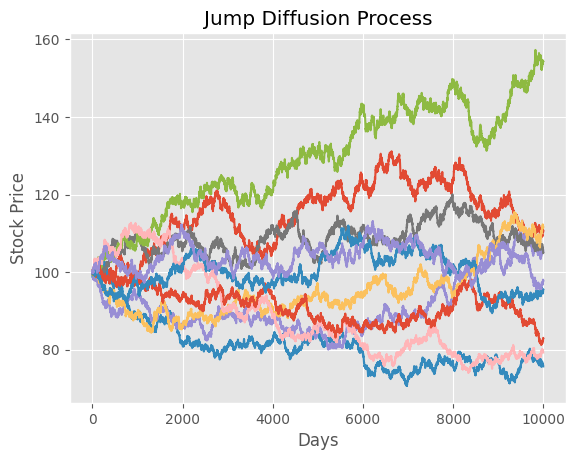

In [6]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
import numpy as np


def merton_jump_paths(S, T, r, sigma, lam, m, v, steps, Npaths):
    size = (steps, Npaths)
    dt = T / steps
    poi_rv = np.multiply(
        np.random.poisson(lam * dt, size=size), np.random.normal(m, v, size=size)
    ).cumsum(axis=0)
    geo = np.cumsum(
        (
            (r - sigma**2 / 2 - lam * (m + v**2 * 0.5)) * dt
            + sigma * np.sqrt(dt) * np.random.normal(size=size)
        ),
        axis=0,
    )

    return np.exp(geo + poi_rv) * S


def simple_gbm(S, T, mu, sigma, steps, Npaths):
    size = (steps, Npaths)
    dt = T / steps
    geo = np.cumsum(
        (
            (mu - sigma**2 / 2) * dt
            + sigma * np.sqrt(dt) * np.random.normal(size=size)
        ),
        axis=0,
    )

    return np.exp(geo) * S


S = 100  # current stock price
T = 1  # time to maturity
r = 0.02  # risk free rate
m = 0  # mean of jump size
v = 0.3  # standard deviation of jump
lam = 0  # intensity of jump i.e. number of jumps per annum
steps = 10000  # time steps
Npaths = 10  # number of paths to simulate
sigma = 0.2  # annaul standard deviation , for weiner process

# j = merton_jump_paths(S, T, r, sigma, lam, m, v, steps, Npaths)
j = simple_gbm(S, T, r, sigma, steps, Npaths)

plt.plot(j)
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.title("Jump Diffusion Process")